# Intuition on calibration and failure prediction

This notebooks contains examples of how to use the calibration and failure prediction modules.
We measure metrics of interest on:
- CIFAR-10 ResNet-18
- RVL-CDIP LayoutLMv3
- Running example from the [presentation](https://www.cvc.uab.es/blog/2023/06/30/jordy-van-landeghem-cvc-seminar/) 

We use the following metrics:
- Accuracy
- F1 score (micro,macro)
- ECE
- Brier score
- Negative Loglikelihood
- AURC

We test the influence of a popular calibration method (Temperature Scaling) on the metrics of interest

In [18]:
%load_ext autoreload
%autoreload 2

In [ ]:
## necessary installs
!pip3 install numpy
!pip3 install scipy
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install pandas
!pip3 install seaborn

## Measuring calibration on CIFAR-10


In [2]:
"""
This testing script loads actual probabilisitic predictions from a resnet finetuned on CIFAR

There are a number of logits-groundtruth pickles available @ https://github.com/markus93/NN_calibration/tree/master/logits
[Seems to have moved from Git-LFS to sharepoint]
https://tartuulikool-my.sharepoint.com/:f:/g/personal/markus93_ut_ee/EmW0xbhcic5Ou0lRbTrySOUBF2ccSsN7lo6lvSfuG1djew?e=l0TErb

See https://github.com/markus93/NN_calibration/blob/master/logits/Readme.txt to decode the [model_dataset] filenames

As a bonus, one could consider temperature scaling and measuring after calibration.
"""
import numpy as np
from scipy.special import softmax
import pickle
from sklearn.model_selection import train_test_split


# Open file with pickled variables
def unpickle_probs(file, verbose=0, normalize=False):
    with open(file, "rb") as f:  # Python 3: open(..., 'rb')
        y1, y2 = pickle.load(f)  # unpickle the content

    if isinstance(y1, tuple):
        y_probs_val, y_val = y1
        y_probs_test, y_test = y2
    else:
        y_probs_val, y_probs_test, y_val, y_test = train_test_split(
            y1, y2.reshape(-1, 1), test_size=len(y2) - 5000, random_state=15
        )  # Splits the data in the ca%load_ext autoreload

    if normalize:
        y_probs_val = softmax(y_probs_val, -1)
        y_probs_test = softmax(y_probs_test, -1)

    if verbose:
        print("y_probs_val:", y_probs_val.shape)  # (5000, 10); Validation set probabilities of predictions
        print("y_true_val:", y_val.shape)  # (5000, 1); Validation set true labels
        print("y_probs_test:", y_probs_test.shape)  # (10000, 10); Test set probabilities
        print("y_true_test:", y_test.shape)  # (10000, 1); Test set true labels

    return ((y_probs_val, y_val.ravel()), (y_probs_test, y_test.ravel()))

In [3]:
import json
from collections import OrderedDict
from metrics import accuracy, brier_loss, nll, f1_micro, f1_macro, aurc_logits, ece_logits  # AUROC_logits

METRICS = [accuracy, brier_loss, nll, f1_micro, f1_macro, ece_logits, aurc_logits]


def apply_metrics(y_true, y_probs, metrics=METRICS):
    predictive_performance = OrderedDict()
    for metric in metrics:
        try:
            predictive_performance[f"{metric.__name__.replace('_logits', '')}"] = metric(y_true, y_probs)
        except Exception as e:
            print(e)
    print(json.dumps(predictive_performance, indent=4))
    return predictive_performance


(p_val, y_val), (p_test, y_test) = unpickle_probs("../data/resnet110_c10_logits.p", verbose=1)
apply_metrics(y_test, p_test)

y_probs_val: (5000, 10)
y_true_val: (5000, 1)
y_probs_test: (10000, 10)
y_true_test: (10000, 1)
'tuple' object has no attribute 'ndim'
{
    "accuracy": 0.9356,
    "brier_loss": 0.11018865559514414,
    "nll": 1.0624524426782735,
    "f1_micro": 0.9356,
    "f1_macro": 0.9356251148224297,
    "ece": 0.05030814408063887
}


OrderedDict([('accuracy', 0.9356),
             ('brier_loss', 0.11018865559514414),
             ('nll', 1.0624524426782735),
             ('f1_micro', 0.9356),
             ('f1_macro', 0.9356251148224297),
             ('ece', 0.05030814408063887)])

## Temperature scaling

In [4]:
from generic_scaling import TemperatureScaler  # TODO: switch to using our metrics [on logits]

T = (
    TemperatureScaler()
)  # DEV: OLD implementation so metric implementations/values might not be similar; use apply_metrics for final verdict :)
T.fit(y_val, p_val)
scaled_logits = T.transform(p_test)
apply_metrics(y_test, scaled_logits)

Before temperature - NLL: 0.300164, ECE: 0.041423
Optimal temperature: 2.395011
After temperature - NLL: 0.180504, ECE: 0.014528
{
    "accuracy": 0.9356,
    "brier_loss": 0.09785229635106264,
    "nll": 0.20926126178358137,
    "f1_micro": 0.9356,
    "f1_macro": 0.9356251148224297,
    "ece": 0.015742955222725875,
    "aurc": 0.008571372340797141
}


OrderedDict([('accuracy', 0.9356),
             ('brier_loss', 0.09785229635106264),
             ('nll', 0.20926126178358137),
             ('f1_micro', 0.9356),
             ('f1_macro', 0.9356251148224297),
             ('ece', 0.015742955222725875),
             ('aurc', 0.008571372340797141)])

## Measuring calibration metrics on a classic DU task

In [5]:
import os, json
import numpy as np
import pandas as pd


def load_json(file_path):
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
    return data


checkpoint_dir = "../data/EElayoutlmv3_jordyvl_rvl_cdip_easyocr_2023-05-16-rvl_cdip_easyocr"
config = load_json(os.path.join(checkpoint_dir, "config.json"))
references = np.load(os.path.join(checkpoint_dir, "references.npz"))["arr_0"]
exit_logits = np.load(os.path.join(checkpoint_dir, "exit_logits.npz"))["arr_0"] #special case of multi-exit network
N = len(references)

In [6]:
# classifier
layoutlmv3_rvlcdip = apply_metrics(references, exit_logits[-1])

df = pd.DataFrame.from_dict(
    layoutlmv3_rvlcdip, orient="index", columns=["layoutlmv3_rvlcdip"]
)  
print(df.to_latex())

'tuple' object has no attribute 'ndim'
{
    "accuracy": 0.9273731843296082,
    "brier_loss": 0.10950648262058199,
    "nll": 1.1471342902044355,
    "f1_micro": 0.9273731843296082,
    "f1_macro": 0.9272251515033926,
    "ece": 0.026558899547747414
}
\begin{tabular}{lr}
\toprule
{} &  layoutlmv3\_rvlcdip \\
\midrule
accuracy   &            0.927373 \\
brier\_loss &            0.109506 \\
nll        &            1.147134 \\
f1\_micro   &            0.927373 \\
f1\_macro   &            0.927225 \\
ece        &            0.026559 \\
\bottomrule
\end{tabular}



# Running calibration example

#### The original data comes from [Gupta & Ramdas 2021](https://openreview.net/pdf?id=WqoBaaPHS-)

In [7]:
import numpy as np

f = np.array(
    [
        [0.1, 0.0, 0.6, 0.3],
        [0.6, 0.0, 0.1, 0.3],
        [0.2, 0.7, 0.0, 0.1],
        [0.0, 0.1, 0.1, 0.8],
        [0.0, 0.1, 0.8, 0.1],
        [0.9, 0.1, 0.0, 0.0],
    ]
)

confidence = np.array([[0.6, 0.6, 0.7, 0.8, 0.8, 0.9]])

predicted_y = np.array([3, 1, 2, 4, 3, 1])
correct_y = np.array([3, 4, 2, 1, 4, 1])
y_correct = correct_y - 1  # 0-indexing

## manual calculation of L1-CE
* basic structure: |I[y==^y| - ^p
* poor statistical approximation since 1 sample per unique continuous value (cannot scale to every unique value and current over-estimation) -> discretization required


In [8]:
manual_ce = (
    abs((3 == 3) - 0.6)
    + abs((4 == 1) - 0.6)
    + abs((2 == 2) - 0.7)
    + abs((1 == 4) - 0.8)
    + abs((4 == 3) - 0.8)
    + abs((1 == 1) - 0.9)
) / 6
manual_ce

0.5000000000000001

## ECE with equal range binning

In [9]:
# Number of bins
num_bins = 10

# Calculate bin boundaries
bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)

# Initialize variables for ECE calculation
bin_confidence = np.zeros(num_bins)
bin_accuracy = np.zeros(num_bins)
bin_counts = np.zeros(num_bins)

# Assign predictions to bins and calculate confidence and accuracy
for i in range(num_bins):
    mask = np.logical_and(confidence >= bin_boundaries[i], confidence < bin_boundaries[i + 1])[0]
    if not any(mask):  # empty bin
        continue
    bin_confidence[i] = np.nanmean(confidence[:, mask])
    bin_accuracy[i] = np.nanmean(correct_y[mask] == predicted_y[mask])
    bin_counts[i] = np.nansum(mask)

print(f"bin_confidence: {bin_confidence} - bin_accuracy: {bin_accuracy} - bin_counts: {bin_counts}")
# Calculate ECE
ece = np.sum(bin_counts / np.sum(bin_counts) * np.abs(bin_accuracy - bin_confidence))

print("Expected Calibration Error (ECE):", ece)

bin_confidence: [0.  0.  0.  0.  0.  0.6 0.7 0.  0.8 0.9] - bin_accuracy: [0.  0.  0.  0.  0.  0.5 1.  0.  0.  1. ] - bin_counts: [0. 0. 0. 0. 0. 2. 1. 0. 2. 1.]
Expected Calibration Error (ECE): 0.36666666666666664


## ECE with equal mass binning

In [10]:
# Calculate bin boundaries for equal-mass binning (skipping equal boundaries)
## for unbiased estimation, require to create equal mass bins on holdout set different from set on which we measure ECE
percentiles = np.linspace(0, 100, num_bins + 1)
bin_boundaries = np.percentile(confidence, percentiles)
bin_boundaries = np.unique(bin_boundaries)

# Initialize variables for ECE calculation
bin_confidence = np.zeros(num_bins)
bin_accuracy = np.zeros(num_bins)
bin_counts = np.zeros(num_bins)

# Assign predictions to bins and calculate confidence and accuracy
for i in range(len(bin_boundaries) - 1):
    mask = np.logical_and(confidence >= bin_boundaries[i], confidence < bin_boundaries[i + 1])[0]
    if not any(mask):  # empty bin
        continue
    bin_confidence[i] = np.nanmean(confidence[:, mask])
    bin_accuracy[i] = np.nanmean(correct_y[mask] == predicted_y[mask])
    bin_counts[i] = np.nansum(mask)

print(f"bin_confidence: {bin_confidence} - bin_accuracy: {bin_accuracy} - bin_counts: {bin_counts}")
# Calculate ECE
ece = np.sum(bin_counts / np.sum(bin_counts) * np.abs(bin_accuracy - bin_confidence))

print("Expected Calibration Error (ECE):", ece)

bin_confidence: [0.6 0.  0.7 0.  0.8 0.  0.  0.  0.  0. ] - bin_accuracy: [0.5 0.  1.  0.  0.  0.  0.  0.  0.  0. ] - bin_counts: [2. 0. 1. 0. 2. 0. 0. 0. 0. 0.]
Expected Calibration Error (ECE): 0.42000000000000004


## Customizable ECE estimator

In [11]:
import evaluate

metric = evaluate.load("jordyvl/ece")
kwargs = dict(
    n_bins=10,
    scheme="equal-range",
    bin_range=None,
    proxy="upper-edge",
    p=1,
    detail=True,
)

# API for entry -> zero-indexing and full samples from probability simplex
results = metric.compute(references=y_correct, predictions=f, **kwargs)
print(results)

{'ECE': 0.37666667302449547, 'y_bar': array([0.60000002, 0.63000002, 0.66000001, 0.69000001, 0.72      ,
       0.75      , 0.78      , 0.80999999, 0.83999999, 0.86999998,
       0.89999998]), 'p_bar': array([nan, 0.5, nan, nan, 1. , nan, nan, 0. , nan, nan, 1. ]), 'bin_freq': array([2, 1, 2, 1]), 'p_bar_cont': 0.73333335, 'accuracy': 0.5}


## Testing the influence of temperature scaling
### simulate two classifiers with equal accuracy and ECE


In [12]:
import numpy as np

# fixed predictions
predicted_y = np.array([3, 1, 2, 4, 3, 1])
correct_y = np.array([3, 4, 2, 1, 4, 1])
y_correct = correct_y - 1  # 0-indexing

f1 = np.array(
    [
        [0.1, 0.0, 0.6, 0.3],
        [0.6, 0.0, 0.1, 0.3],
        [0.2, 0.7, 0.0, 0.1],
        [0.0, 0.1, 0.1, 0.8],
        [0.0, 0.1, 0.8, 0.1],
        [0.9, 0.1, 0.0, 0.0],
    ]
)

c1 = np.array([0.6, 0.6, 0.7, 0.8, 0.8, 0.9])


from generic_scaling import TemperatureScaler  # switch to using our metrics [on logits]

T = TemperatureScaler()
T.fit(y_correct, f1)
optimal_temperature = T.temperature.item()
scaled_f = T.transform(f1)
print(scaled_f, optimal_temperature)

Before temperature - NLL: 1.250760, ECE: 0.286734
Optimal temperature: 0.563997
After temperature - NLL: 1.218173, ECE: 0.281184
[[0.17575181 0.1471963  0.42649541 0.25055648]
 [0.42649541 0.1471963  0.17575181 0.25055648]
 [0.20138306 0.48869454 0.14125932 0.16866308]
 [0.13300191 0.15880377 0.15880377 0.54939055]
 [0.13300191 0.15880377 0.54939055 0.15880377]
 [0.6069427  0.14693471 0.1230613  0.1230613 ]] 0.5639974842995397


In [13]:
eps = 1e-12


def softmax(x, axis=-1):
    # Subtract the maximum value for numerical stability
    x = x - np.max(x, axis=axis, keepdims=True)

    # Compute the exponentials of the shifted input
    exps = np.exp(x)

    # Compute the sum of exponentials along the last axis
    exps_sum = np.sum(exps, axis=axis, keepdims=True)

    # Compute the softmax probabilities
    softmax_probs = exps / exps_sum

    return softmax_probs


def posterior_tempering(probs, T=1, randomized_temperature=False):
    """
    if randomized_temperature, T is the max temperature
    DEV: still a monotonic transformation? Guess not :)
    """
    start = eps if T < 1 else 1
    T = np.ones(len(probs)) * T
    if randomized_temperature:
        T = np.random.uniform(start, T, len(probs))
    probs = np.log(np.clip(probs, eps, 1 - eps))  # all above eps -> remove
    return softmax(probs * T[:, None], axis=-1)


f2 = posterior_tempering(f1, T=0.8)
c2 = np.max(f2, axis=-1)

f3 = posterior_tempering(f1, T=0.8, randomized_temperature=True)
c3 = np.max(f3, axis=-1)

f4 = posterior_tempering(f1, T=2)
c4 = np.max(f4, axis=-1)

f5 = posterior_tempering(f1, T=2, randomized_temperature=True)
c5 = np.max(f5, axis=-1)

c1, c2, c3, c4, c5

(array([0.6, 0.6, 0.7, 0.8, 0.8, 0.9]),
 array([0.55161944, 0.55161944, 0.63375697, 0.72520043, 0.72520043,
        0.85293136]),
 array([0.47120526, 0.3877564 , 0.38271506, 0.52941715, 0.55366495,
        0.26734813]),
 array([0.7826087 , 0.7826087 , 0.90740741, 0.96969697, 0.96969697,
        0.98780488]),
 array([0.740997  , 0.77648361, 0.90427748, 0.95613913, 0.81401324,
        0.96939783]))

[1 2 3 4 5 6]


<ipython-input-14-ddc99653cb8c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "i", "ii", "iii", "iv", "v", "vi"])


<Figure size 720x432 with 0 Axes>

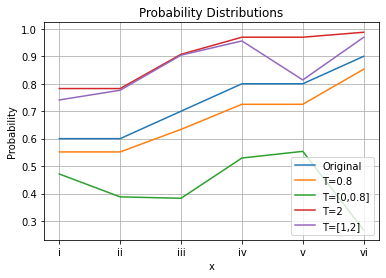

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt


# Create x-axis values
x = np.arange(1, len(c1) + 1)
print(x)

# Plot the probability distributions
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1, 1)

plt.plot(x, c1, label="Original")
plt.plot(x, c2, label="T=0.8")
plt.plot(x, c3, label="T=[0,0.8]")
plt.plot(x, c4, label="T=2")
plt.plot(x, c5, label="T=[1,2]")


# Set plot title and labels
plt.title("Probability Distributions")
plt.xlabel("x")
plt.ylabel("Probability")
ax.set_xticklabels(["", "i", "ii", "iii", "iv", "v", "vi"])

# Set legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.savefig("probabilities tempering.png")

In [15]:
import pandas as pd

classifiers = [f1, f2, f3, f4, f5]

labels = ["Original", "T=0.8", "T=[0,0.8]", "T=2", "T=[1,2]"]

collect = {}
for i, f in enumerate(classifiers):
    collect[f"f{i+1}: {labels[i]}"] = apply_metrics(y_correct, f)
    collect[f"f{i+1}: {labels[i]}"]["ECE eqr"] = metric.compute(references=y_correct, predictions=f, detail=False)[
        "ECE"
    ]
    # T-scale f -> all monotonic should end up the same

collect[f"T opt"] = apply_metrics(y_correct, scaled_f)


df = pd.DataFrame(collect)
# to latex
print(df.to_latex(index=True))

{
    "accuracy": 0.5,
    "brier_loss": 0.7333333333333333,
    "nll": 6.503032562598869,
    "f1_micro": 0.5,
    "f1_macro": 0.5416666666666666,
    "ece": 0.39999998609224957,
    "aurc": 0.4833333333333333
}
{
    "accuracy": 0.5,
    "brier_loss": 0.7014934828531983,
    "nll": 4.431991197590558,
    "f1_micro": 0.5,
    "f1_macro": 0.5416666666666666,
    "ece": 0.3746960560480754,
    "aurc": 0.41944444444444445
}
{
    "accuracy": 0.5,
    "brier_loss": 0.7877025048930953,
    "nll": 2.8235275120135603,
    "f1_micro": 0.5,
    "f1_macro": 0.5416666666666666,
    "ece": 0.6208302726348242,
    "aurc": 0.6277777777777777
}
{
    "accuracy": 0.5,
    "brier_loss": 0.8686460218982747,
    "nll": 6.785734042528073,
    "f1_micro": 0.5,
    "f1_macro": 0.5416666666666666,
    "ece": 0.47012126445770264,
    "aurc": 0.4833333333333333
}
{
    "accuracy": 0.5,
    "brier_loss": 0.7980645307188348,
    "nll": 6.4923436225312585,
    "f1_micro": 0.5,
    "f1_macro": 0.5416666666666666,

## Risk-coverage curves


In [20]:
from metrics import aurc_logits, multi_aurc_plot

aurcs = []
caches = []
for i, f in enumerate(classifiers):
    res = aurc_logits(y_correct, f, plot=False, get_cache=True)
    aurc, cache = res['aurc'], res['cache']
    aurcs.append(aurc)
    caches.append(cache)
    
multi_aurc_plot(caches, labels)

          Original     T=0.8  T=[0,0.8]       T=2   T=[1,2]
1.000000  0.500000  0.500000   0.500000  0.500000  0.500000
0.833333  0.600000  0.600000   0.600000  0.600000  0.600000
0.500000  0.666667  0.666667   0.666667  0.666667  0.333333
0.333333  0.500000  0.500000   1.000000  0.500000  0.500000
0.000000  0.500000       NaN        NaN  0.500000       NaN


In [ ]:
df

,f0,f1,f2,f3,f4
accuracy,0.500000,0.500000,0.500000,0.500000,0.500000
brier_loss,0.733333,0.701493,0.712969,0.868646,0.855173
nll,6.503033,4.431991,3.227383,6.785734,6.789682
f1_micro,0.500000,0.500000,0.500000,0.500000,0.500000
f1_macro,0.541667,0.541667,0.541667,0.541667,0.541667
ece,0.400000,0.374696,0.408064,0.470121,0.516319
